In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from src import camvid
from src import bayesian_segnet
from src.utils import history_to_results
from src.utils import heatmap

In [3]:
!mkdir -p models
weights_file = 'models/BayesianSegNet-CamVid11.h5'

In [4]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [5]:
batch_size = 4
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to
crop_size = (352, 480)

In [6]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Training

In [7]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=crop_size, batch_size=batch_size)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


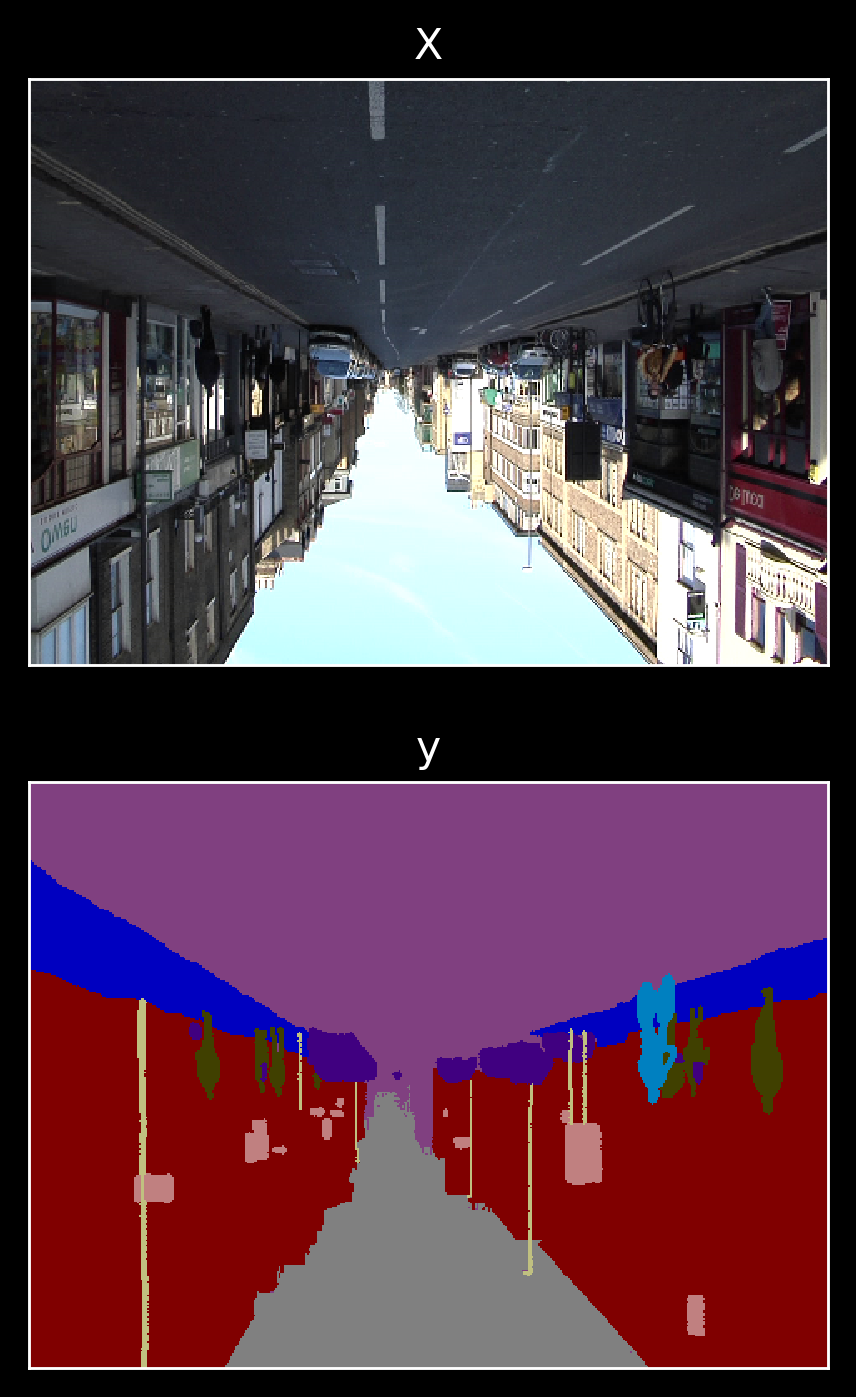

In [8]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [9]:
# build the model for the image shape and number of labels
model = bayesian_segnet.build_bayesian_segnet((*crop_size, 3), camvid11.n, 
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,
)

In [ ]:
# create a checkpoint callback to keep the best weights according
# to the training loss
checkpoint = ModelCheckpoint(weights_file, 
    monitor='loss', 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min'
)
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=50,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=[checkpoint, EarlyStopping(monitor='loss', patience=10)],
    verbose=1
)

In [ ]:
history_to_results(history)

## Load Best Model

In [ ]:
model.load_weights(weights_file)

# Test Metrics

In [10]:
# wrap the SegNet with a MonteCarlo estimator of mean and variance
bayesian_model = bayesian_segnet.wrap_monte_carlo(model, 
    num_samples=40,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights
)

In [ ]:
# metrics = bayesian_model.evaluate_generator(generators['test'], steps=233)
# names = bayesian_model.metrics_names
# pd.DataFrame(metrics, names, columns=['val'])

# Qualitative Results

In [16]:
def predict(generator):
    X, y = next(generator)
#     p, s = bayesian_model.predict(X)
    p, s = bayesian_model([X])
    return X, camvid11.unmap(y), camvid11.unmap(p), heatmap(s)

### Train Results

In [17]:
X, y, p, s = predict(generators['train'])

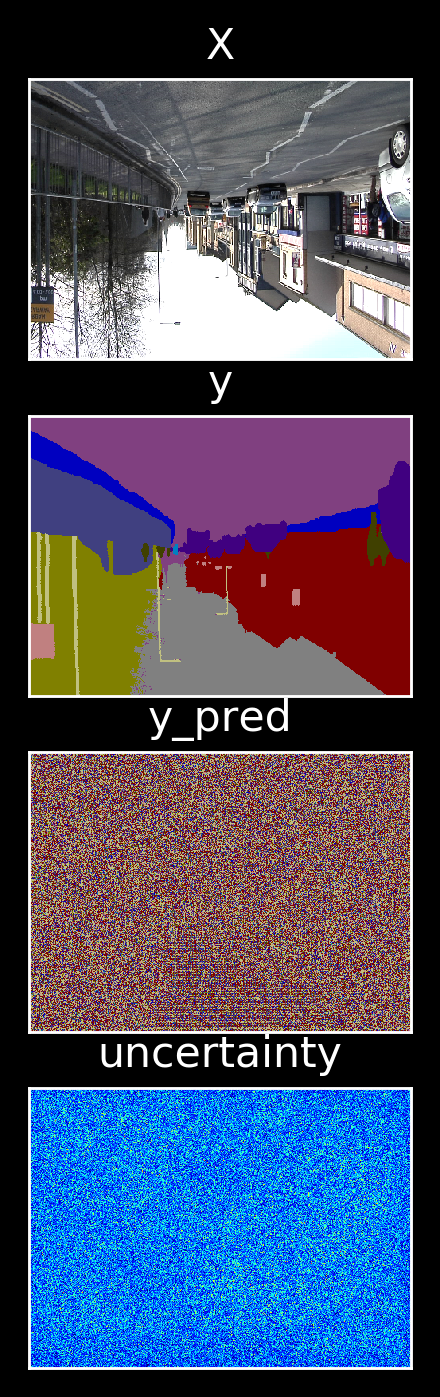

In [19]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], uncertainty=s[1])

In [ ]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], uncertainty=s[2])

In [ ]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], uncertainty=s[3])

### Validation Results

In [ ]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

### Test Results

In [ ]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])

In [ ]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0])